In [1]:
import pandas as pd
import numpy as np

In [11]:
import fnmatch 
import os 
  
pattern = 'revs_*.csv'
print('Pattern :', pattern )
  
files = os.listdir('../data/small_dataset/') 
dfs_files = []
for name in files: 
    if fnmatch.fnmatch(name, pattern):
        dfs_files.append(name)
dfs_files
dfs_paths = []
for file in dfs_files:
    dfs_paths.append('../data/small_dataset/' + file)

Pattern : revs_*.csv


In [37]:
revs_dfs = []
for file in dfs_paths:
    revs_dfs.append(pd.read_csv(file))
    
revs_df = pd.concat(revs_dfs)

revs_df['UserID'] = revs_df.user_link.astype('category').cat.codes

revs_df.info()

revsdf = revs_df[['isbn','UserID','ranking']]

reviews_df = revsdf.rename(columns={"ranking":"Rating", 'isbn':'ISBN'})

In [68]:
#droping raws with UserID == 0
reviews_df.drop(reviews_df[reviews_df['UserID']==0].index, axis=0,inplace=True)
reviews_df.drop(reviews_df[reviews_df['Rating']==0].index, axis=0,inplace=True)

In [84]:
reviews_df['ISBN'].value_counts()

1984819194    75
385539304     75
965900584     75
60556579      75
385495323     75
              ..
142003344      8
143036556      8
393348741      8
544272994      8
802714625      8
Name: ISBN, Length: 93, dtype: int64

In [108]:
reviews_df.describe()

,UserID,Rating
count,4406.000000,4406.000000
mean,6913.781207,3.960508
std,4002.581711,1.027558
min,5.000000,1.000000
25%,3527.000000,3.000000
50%,6845.000000,4.000000
75%,10373.750000,5.000000
max,13928.000000,5.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f853f674790>,
      dtype=object)

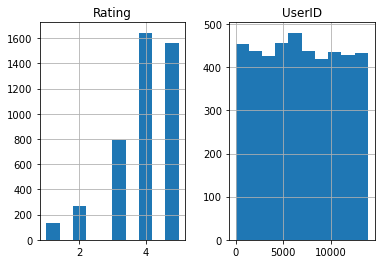

In [109]:
reviews_df.hist()